## Task: Take halved and shuffled MNIST test set images and reconstruct the test set

Approach: Generate a prior distribution per pixel based on the training set, per label. Then assign the max probability of each pixel distribution to the corresponding pixel in the shuffled image. We just use the histogram of the shuffled image and call this the 'pixel budget'

In [1]:
#random shuffle transform
class RandomShuffle(object):
    def __call__(self, img):
        left = img[:,:,0:14].flatten()
        right = img[:,:,14:28].flatten()
        left = left[torch.randperm(len(left))].reshape(1,28,14)
        right = right[torch.randperm(len(right))].reshape(1,28,14)
        img[:,:,0:14] = left
        img[:,:,14:28] = right
        return img

    

### Data Loading

In [2]:
import torch
import torchvision

batch_size=128
norm_tsfm = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])
shuffle_tsfm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                               RandomShuffle()
                             ])

train_set = torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=norm_tsfm)
shuffle_train_set = torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=shuffle_tsfm)


test_set = torchvision.datasets.MNIST('.', train=False, download=True,
                             transform=norm_tsfm)

shuffle_test_set = torchvision.datasets.MNIST('.', train=False, download=True,
                             transform=shuffle_tsfm)

#train_loader = torch.utils.data.DataLoader(train_set,
#  batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_set,
#  batch_size=batch_size, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Per-pixel probability map generator functions
'gen_prob_map' will take the whole test set and generate intensity distributions per pixel

'gen_prob_map_exemp' will only take the top k neighbors, matched by the histogram of the shuffled image

'weights' is a parameter that will weight each training image by its histogram similarity to the input histogram

For now, histogram distance is measured by simple L2 distance, better metrics such as KL-divergence can be used

In [53]:
def gen_prob_map(target_lbl, hist=None, weights=False):
    tidxs = (train_set.targets==target_lbl)
    sub_data = train_set.data[tidxs]
    prob_map = torch.zeros(28,28,256)
        
    if weights:
        hists = torch.zeros(sub_data.shape[0], 256)
        for i,s in enumerate(sub_data):
            hists[i] = torch.bincount(s.flatten(), minlength=256)
        norms = torch.linalg.norm(hists - hist, dim=1)
        norms = torch.max(norms) - norms + 1
        for i in range(sub_data.shape[1]):
            for j in range(sub_data.shape[2]):  
                prob_map[i,j] = torch.bincount(sub_data[:,i,j], weights=norms, minlength=256)#/sub_data.shape[0]

    else:
        for i in range(sub_data.shape[1]):
            for j in range(sub_data.shape[2]):    
                prob_map[i,j] = torch.bincount(sub_data[:,i,j], minlength=256)#/sub_data.shape[0]

    return prob_map

def gen_prob_map_exemp(target, hist, k, weights=False):
    tidxs = (train_set.targets==target_lbl)
    sub_data = train_set.data[tidxs]
    hists = torch.zeros(sub_data.shape[0], 256)
    for i,s in enumerate(sub_data):
        hists[i] = torch.bincount(s.flatten(), minlength=256)
    norms = torch.linalg.norm(hists - hist, dim=1)
    knn = norms.topk(k, largest=False)
    sub_knn = sub_data[knn.indices]
    prob_map = torch.zeros(28,28,256)
    if weights:
        norms = torch.max(knn.values) - knn.values + 1
        for i in range(sub_knn.shape[1]):
            for j in range(sub_knn.shape[2]):
                prob_map[i,j] = torch.bincount(sub_knn[:,i,j],weights=norms,minlength=256)#/sub_knn.shape[0]
    else:
        for i in range(sub_knn.shape[1]):
            for j in range(sub_knn.shape[2]):
                prob_map[i,j] = torch.bincount(sub_knn[:,i,j], minlength=256)#/sub_knn.shape[0]

    return prob_map



### Example Prob maps

torch.Size([28, 28])


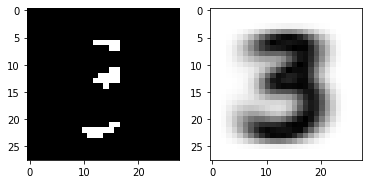

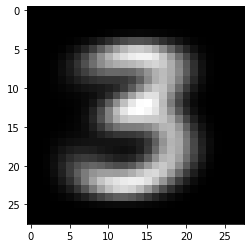

In [13]:
prob_map = gen_prob_map(3)
max_val, max_map = torch.max(prob_map,dim=2)

exp_map = torch.sum(prob_map * torch.arange(256), dim=2)
print(max_map.shape)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(max_map, cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(max_val, cmap='gray')
plt.figure()
plt.imshow(exp_map, cmap='gray')

### Shuffled vs original image

tensor(9.0241)


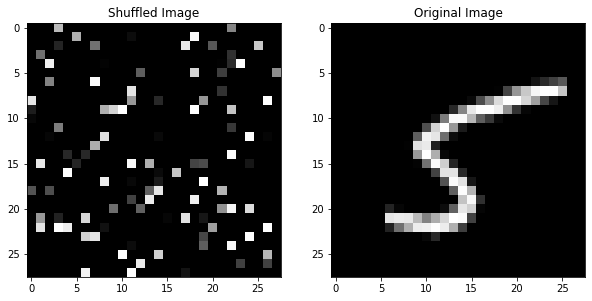

In [60]:
import random
target_lbl=6
prob_map = gen_prob_map(target_lbl)
stidxs = torch.nonzero((shuffle_train_set.targets==target_lbl))
i = random.randint(0, stidxs.shape[0]-1)
stidx = int(stidxs[i])
#sub_shuf_data = shuffle_train_set[stidxs]
sub_shuf_target = shuffle_train_set.targets[stidxs]
orig_img, orig_lbl = train_set[stidx]
test_img, test_lbl = shuffle_train_set[stidx]
fig = plt.figure(figsize=(10,20))
fig.add_subplot(1,2,1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('Shuffled Image')
fig.add_subplot(1,2,2)
plt.imshow(orig_img.squeeze(), cmap='gray')
plt.title('Original Image')
print(torch.linalg.norm(test_img.squeeze() - orig_img.squeeze(), dim=(0,1)))
test_img = (255*test_img).type(torch.uint8).squeeze()

### Reconstruction algorithm
'reconstruct_image' does not consider the fact that the test set was bisected vertically and shuffled independently, 'reconstruct_from_halves' does

The images below don't have probability maps weighted by the histogram distance (weights = False). KNN histogram means that the top k histogram neighbors from the test set are used to construct the probability map

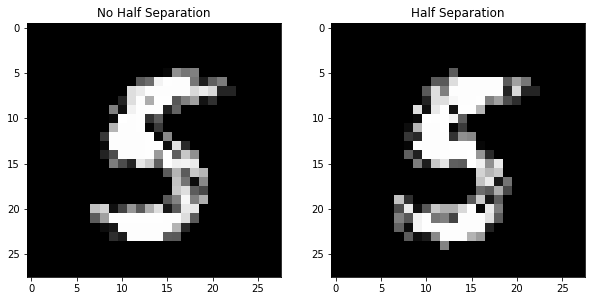

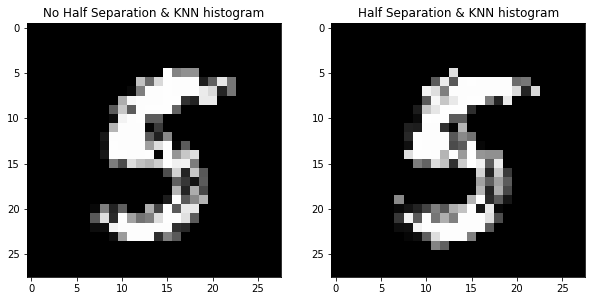

In [51]:
import random
def reconstruct_image(test_img, prob_map):
    cp_prob_map = torch.clone(prob_map)
    rec_img = torch.zeros_like(test_img, dtype=torch.uint8)
    test_img_cts = torch.bincount(test_img.flatten(), minlength=256)
    #print(test_img_cts)
    ctr = 0
    while ctr < test_img.shape[0]*test_img.shape[1]:
        val = torch.max(cp_prob_map)
        ixs = (cp_prob_map==val).nonzero()
        rand = random.randint(0,ixs.shape[0]-1)
        ix = ixs[0]
        pix_val = ix[2]
        #print(pix_val)
        #print(ix)
        if(test_img_cts[pix_val] > 0): # if we have pixel budget assign
            rec_img[ix[0],ix[1]] = pix_val #assignment
            test_img_cts[pix_val] -= 1 # reduce pixel budget
            cp_prob_map[ix[0],ix[1],:] = -1 # don't get this as max prob map
            ctr += 1
        else:   # else don't get these pixel 
            cp_prob_map[:,:,pix_val] = -1
    #print(test_img_cts)
    return rec_img

def reconstruct_from_halves(img, prob_map):
    left_rec = reconstruct_image(img[:,0:14], prob_map[:,0:14])
    right_rec = reconstruct_image(img[:,14:28], prob_map[:,14:28])
    return torch.cat((left_rec,right_rec), 1)


hist = torch.bincount(test_img.flatten(), minlength=256)
prob_map = gen_prob_map(target_lbl)
prob_map_e = gen_prob_map_exemp(target_lbl, hist,2000)
rec = reconstruct_image(test_img, prob_map)
better_rec = reconstruct_from_halves(test_img, prob_map)
rec_e = reconstruct_image(test_img, prob_map_e)
better_rec_e = reconstruct_from_halves(test_img, prob_map_e)

fig1 = plt.figure(figsize=(10,20))
fig1.add_subplot(1,2,1)
plt.imshow(rec, cmap='gray')
plt.title("No Half Separation");
fig1.add_subplot(1,2,2)
plt.imshow(better_rec, cmap='gray')
plt.title("Half Separation");
fig2 = plt.figure(figsize=(10,20))
fig2.add_subplot(1,2,1)
plt.imshow(rec_e, cmap='gray')
plt.title("No Half Separation & KNN histogram");
fig2.add_subplot(1,2,2)
plt.imshow(better_rec_e, cmap='gray')
plt.title("Half Separation & KNN histogram");


#### The images below have probability maps that consider samples weighted by the histogram distance

WITH WEIGHTS


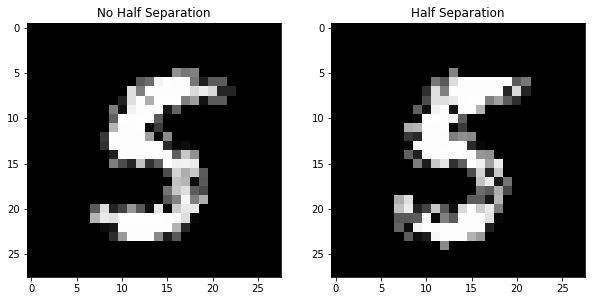

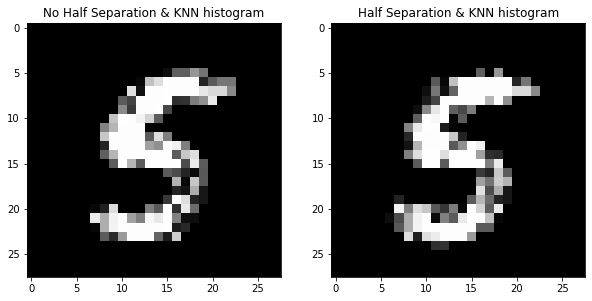

In [54]:
hist = torch.bincount(test_img.flatten(), minlength=256)
prob_map = gen_prob_map(target_lbl, hist=hist, weights=True)
prob_map_e = gen_prob_map_exemp(target_lbl, hist,1000, weights=True)
rec = reconstruct_image(test_img, prob_map)
better_rec = reconstruct_from_halves(test_img, prob_map)
rec_e = reconstruct_image(test_img, prob_map_e)
better_rec_e = reconstruct_from_halves(test_img, prob_map_e)
print('WITH WEIGHTS')
fig1 = plt.figure(figsize=(10,20))
fig1.add_subplot(1,2,1)
plt.imshow(rec, cmap='gray')
plt.title("No Half Separation");
fig1.add_subplot(1,2,2)
plt.imshow(better_rec, cmap='gray')
plt.title("Half Separation");
fig2 = plt.figure(figsize=(10,20))
fig2.add_subplot(1,2,1)
plt.imshow(rec_e, cmap='gray')
plt.title("No Half Separation & KNN histogram");
fig2.add_subplot(1,2,2)
plt.imshow(better_rec_e, cmap='gray')
plt.title("Half Separation & KNN histogram");


### Considerations for the future:
- Implementing continuity constraints for the images can boost scores, as all of the input images are aliased and don't contain high spatial frequencies
- Possibly smoothing the probability map histograms may help (e.g Laplacian smoothing) to give the intermediate intensity values a chance
- Finding histogram neighbors by using better metrics such as KL-divergence
- Batching the input to improve performance

In [ ]:
import matplotlib.pyplot as plt
import tqdm.notebook as tq 
%matplotlib inline
targets = torch.arange(10)
l2s = torch.zeros(5,1000)
for target in targets:
    stidxs = (shuffle_train_set.targets==target).nonzero()
    prob_map = gen_prob_map(target)
    for i in tq.tqdm(range(100)):
        stidx = int(stidxs[i])
        orig_img, orig_lbl = test_set[stidx]
        shuf_img, shuf_lbl = shuffle_test_set[stidx]
        orig_img = (orig_img*255).type(torch.uint8).squeeze()
        shuf_img = (shuf_img*255).type(torch.uint8).squeeze()
        #prob_map = gen_prob_map_exemp(pr)
        rec_img = reconstruct_image(shuf_img, prob_map)
        l2s[0,i] = torch.linalg.norm((rec_img.float() - orig_img.float())/255., dim=(0,1))
        rec_img = reconstruct_from_halves(shuf_img, prob_map)
        l2s[1,i] = torch.linalg.norm((rec_img.float() - orig_img.float())/255., dim=(0,1))
        
        shuf_hist = torch.bincount(shuf_img.flatten(), minlength=256)
        prob_map =  gen_prob_map_exemp(target, shuf_hist,1000)
        rec_img = reconstruct_image(shuf_img, prob_map)
        l2s[2,i] = torch.linalg.norm((rec_img.float() - orig_img.float())/255., dim=(0,1))
        rec_img = reconstruct_from_halves(shuf_img, prob_map)
        l2s[3,i] = torch.linalg.norm((rec_img.float() - orig_img.float())/255., dim=(0,1))
        
        l2s[4,i] = torch.linalg.norm((shuf_img.float() - orig_img.float())/255., dim=(0,1))



  0%|          | 0/100 [00:00<?, ?it/s]